In [ ]:
bills = "../../data/bills/2023/MA/2023-2024_193rd_General_Court/bill"
#!ls
#!pip install networkx
import networkx as nx
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import json
import numpy as np


In [19]:
people = "../../data/bills/2023/MA/2023-2024_193rd_General_Court/people"
bills = "../../data/bills/2023/MA/2023-2024_193rd_General_Court/bill"
votes = "../../data/bills/2023/MA/2023-2024_193rd_General_Court/vote"

In [21]:
def make_bill_json_df(source: str, save: bool = False) -> pd.DataFrame:
    json_files = glob.glob(os.path.join(source, "*.json"))
    columns = [
        "bill_id",
        "status",
        "state",
        "state_id",
        "bill_number",
        "bill_type",
        "bill_type_id",
        "body",
        "body_id",
        "current_body",
        "current_body_id",
        "title",
        "description"
    ]
    data = []
    for file in json_files:
        with open(file, "r") as f:
            json_data = json.load(f)
            row = json_data.get("bill")
            row = {col: row.get(col, None) for col in columns}
            data.append(row)
    response = pd.DataFrame(data)
    if save:
        response.to_csv('bill.csv')
    return response


bills_df = make_bill_json_df(bills)

In [22]:
bills_df.head()

,bill_id,status,state,state_id,bill_number,bill_type,bill_type_id,body,body_id,current_body,current_body_id,title,description
0,1735700,1,MA,21,S386,B,1,S,52,S,52,Relative to disclosing continuing care retirem...,For legislation relative to disclosing continu...
1,1879555,1,MA,21,H4660,B,1,H,51,H,51,Similar Bills,Similar Bills
2,1739848,1,MA,21,H2392,B,1,H,51,H,51,Relative to the return of firearms,Relative to the return of firearms stored at p...
3,1737219,1,MA,21,S1998,B,1,S,52,S,52,To SAVE tax dollars in the Commonwealth,For legislation to SAVE tax dollars in the Com...
4,1775753,1,MA,21,H4030,B,1,H,51,H,51,Relative to public comments and open meeting law,Relative to public comments and open meeting l...


In [23]:
#bills_df.to_csv('bill.csv')

In [24]:
titles = pd.read_csv("bill.csv")

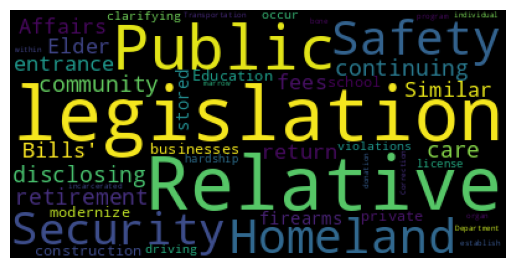

In [25]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
text = titles['description'].values

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [26]:
def make_people_json_df(source: str, save: bool = False) -> pd.DataFrame:
    json_files = glob.glob(os.path.join(source, "*.json"))
    columns = ["people_id", "name", "party", "state_id", "role", "district"]
    data = []
    for file in json_files:
        with open(file, "r") as f:
            row = json.load(f)
            row = row.get("person")
            row = {col: row.get(col, None) for col in columns}
            data.append(row)
    df = pd.DataFrame(data)
    if save:
        df.to_csv("people.csv", index=False)
    return df

In [27]:
def make_votes_json_df(source: str, save: bool = False) -> pd.DataFrame:
    json_files = glob.glob(os.path.join(source, "*.json"))
    records = []
    for file in json_files:
        with open(file, "r") as f:
            json_data = json.load(f)
            json_data = json_data.get("roll_call")
            base_info = {
                "roll_call_id": json_data["roll_call_id"],
                "bill_id": json_data["bill_id"],
                "date": json_data["date"],
                "desc": json_data["desc"],
                "passed": json_data["passed"],
                "chamber": json_data["chamber"]
            }
            for v in json_data.get("votes"):
                record = {
                    **base_info,
                    "people_id": v["people_id"],
                    "vote_text": v["vote_text"]
                }
                records.append(record)
    df = pd.DataFrame(records)
    if save:
        df.to_csv("votes.csv", index=False)
    return df


In [30]:
people_df = make_people_json_df(people, save=True)
votes_df =make_votes_json_df(votes, save=True)

In [31]:
people_df.head()

,people_id,name,party,state_id,role,district
0,21656,Carol Doherty,D,21,Rep,HD-03-BRI
1,23092,"Advanced Information Technology, the Internet ...",,21,Jnt,
2,2493,Alice Peisch,D,21,Rep,HD-14-NOR
3,2506,Michael Rodrigues,D,21,Sen,SD-01-PLY
4,16186,Jeffrey Roy,D,21,Rep,HD-10-NOR


In [32]:
votes_df.head()

,roll_call_id,bill_id,date,desc,passed,chamber,people_id,vote_text
0,1355849,1775764,2023-10-05,"Senate Question on passing item 7004-3036, not...",1,S,2403,Yea
1,1355849,1775764,2023-10-05,"Senate Question on passing item 7004-3036, not...",1,S,2404,Yea
2,1355849,1775764,2023-10-05,"Senate Question on passing item 7004-3036, not...",1,S,2435,Yea
3,1355849,1775764,2023-10-05,"Senate Question on passing item 7004-3036, not...",1,S,2463,Yea
4,1355849,1775764,2023-10-05,"Senate Question on passing item 7004-3036, not...",1,S,2471,Yea


In [33]:
def link_people_to_bills(people_df: pd.DataFrame, bills_df: pd.DataFrame, votes_df: pd.DataFrame) -> pd.DataFrame:
    merged = votes_df.merge(people_df, on="people_id", how="left")
    merged = merged.merge(bills_df, on="bill_id", how="left")
    #print(merged.columns)
    response = merged.drop(columns=["description", "vote_text", "desc", "title"])
    return response
linked_df = link_people_to_bills(people_df, arf, votes_df)
linked_df.to_csv("politician_bill_links.csv", index=False)

In [34]:
linked_df.head()

,roll_call_id,bill_id,date,passed,chamber,people_id,name,party,state_id_x,role,...,status,state,state_id_y,bill_number,bill_type,bill_type_id,body,body_id,current_body,current_body_id
0,1355849,1775764,2023-10-05,1,S,2403,Michael Brady,D,21,Sen,...,5,MA,21,H4040,B,1,H,51,H,51
1,1355849,1775764,2023-10-05,1,S,2404,William Brownsberger,D,21,Sen,...,5,MA,21,H4040,B,1,H,51,H,51
2,1355849,1775764,2023-10-05,1,S,2435,Barry Finegold,D,21,Sen,...,5,MA,21,H4040,B,1,H,51,H,51
3,1355849,1775764,2023-10-05,1,S,2463,John Keenan,D,21,Sen,...,5,MA,21,H4040,B,1,H,51,H,51
4,1355849,1775764,2023-10-05,1,S,2471,Jason Lewis,D,21,Sen,...,5,MA,21,H4040,B,1,H,51,H,51


Research on graphs:

https://en.wikipedia.org/wiki/Bipartite_graph

Trying out weighted, undirected

In [ ]:

same_vote_edges = defaultdict(int)
#TODO fix the self-loop in this later
for bill_id, group in votes_df.groupby("bill_id"):
    for vote_type, subgroup in group.groupby("vote_text"):
        voters = list(subgroup["people_id"])
        for a, b in combinations(sorted(voters), 2):
            same_vote_edges[(a, b)] += 1

G_covote = nx.Graph()
G_covote.add_nodes_from(votes_df["people_id"].unique())

for (a, b), weight in same_vote_edges.items():
    G_covote.add_edge(a, b, weight=weight)

Are most politicians only lightly aligned? Are there strong blocs?

IDEA: We can experiment also with betweeness centrality

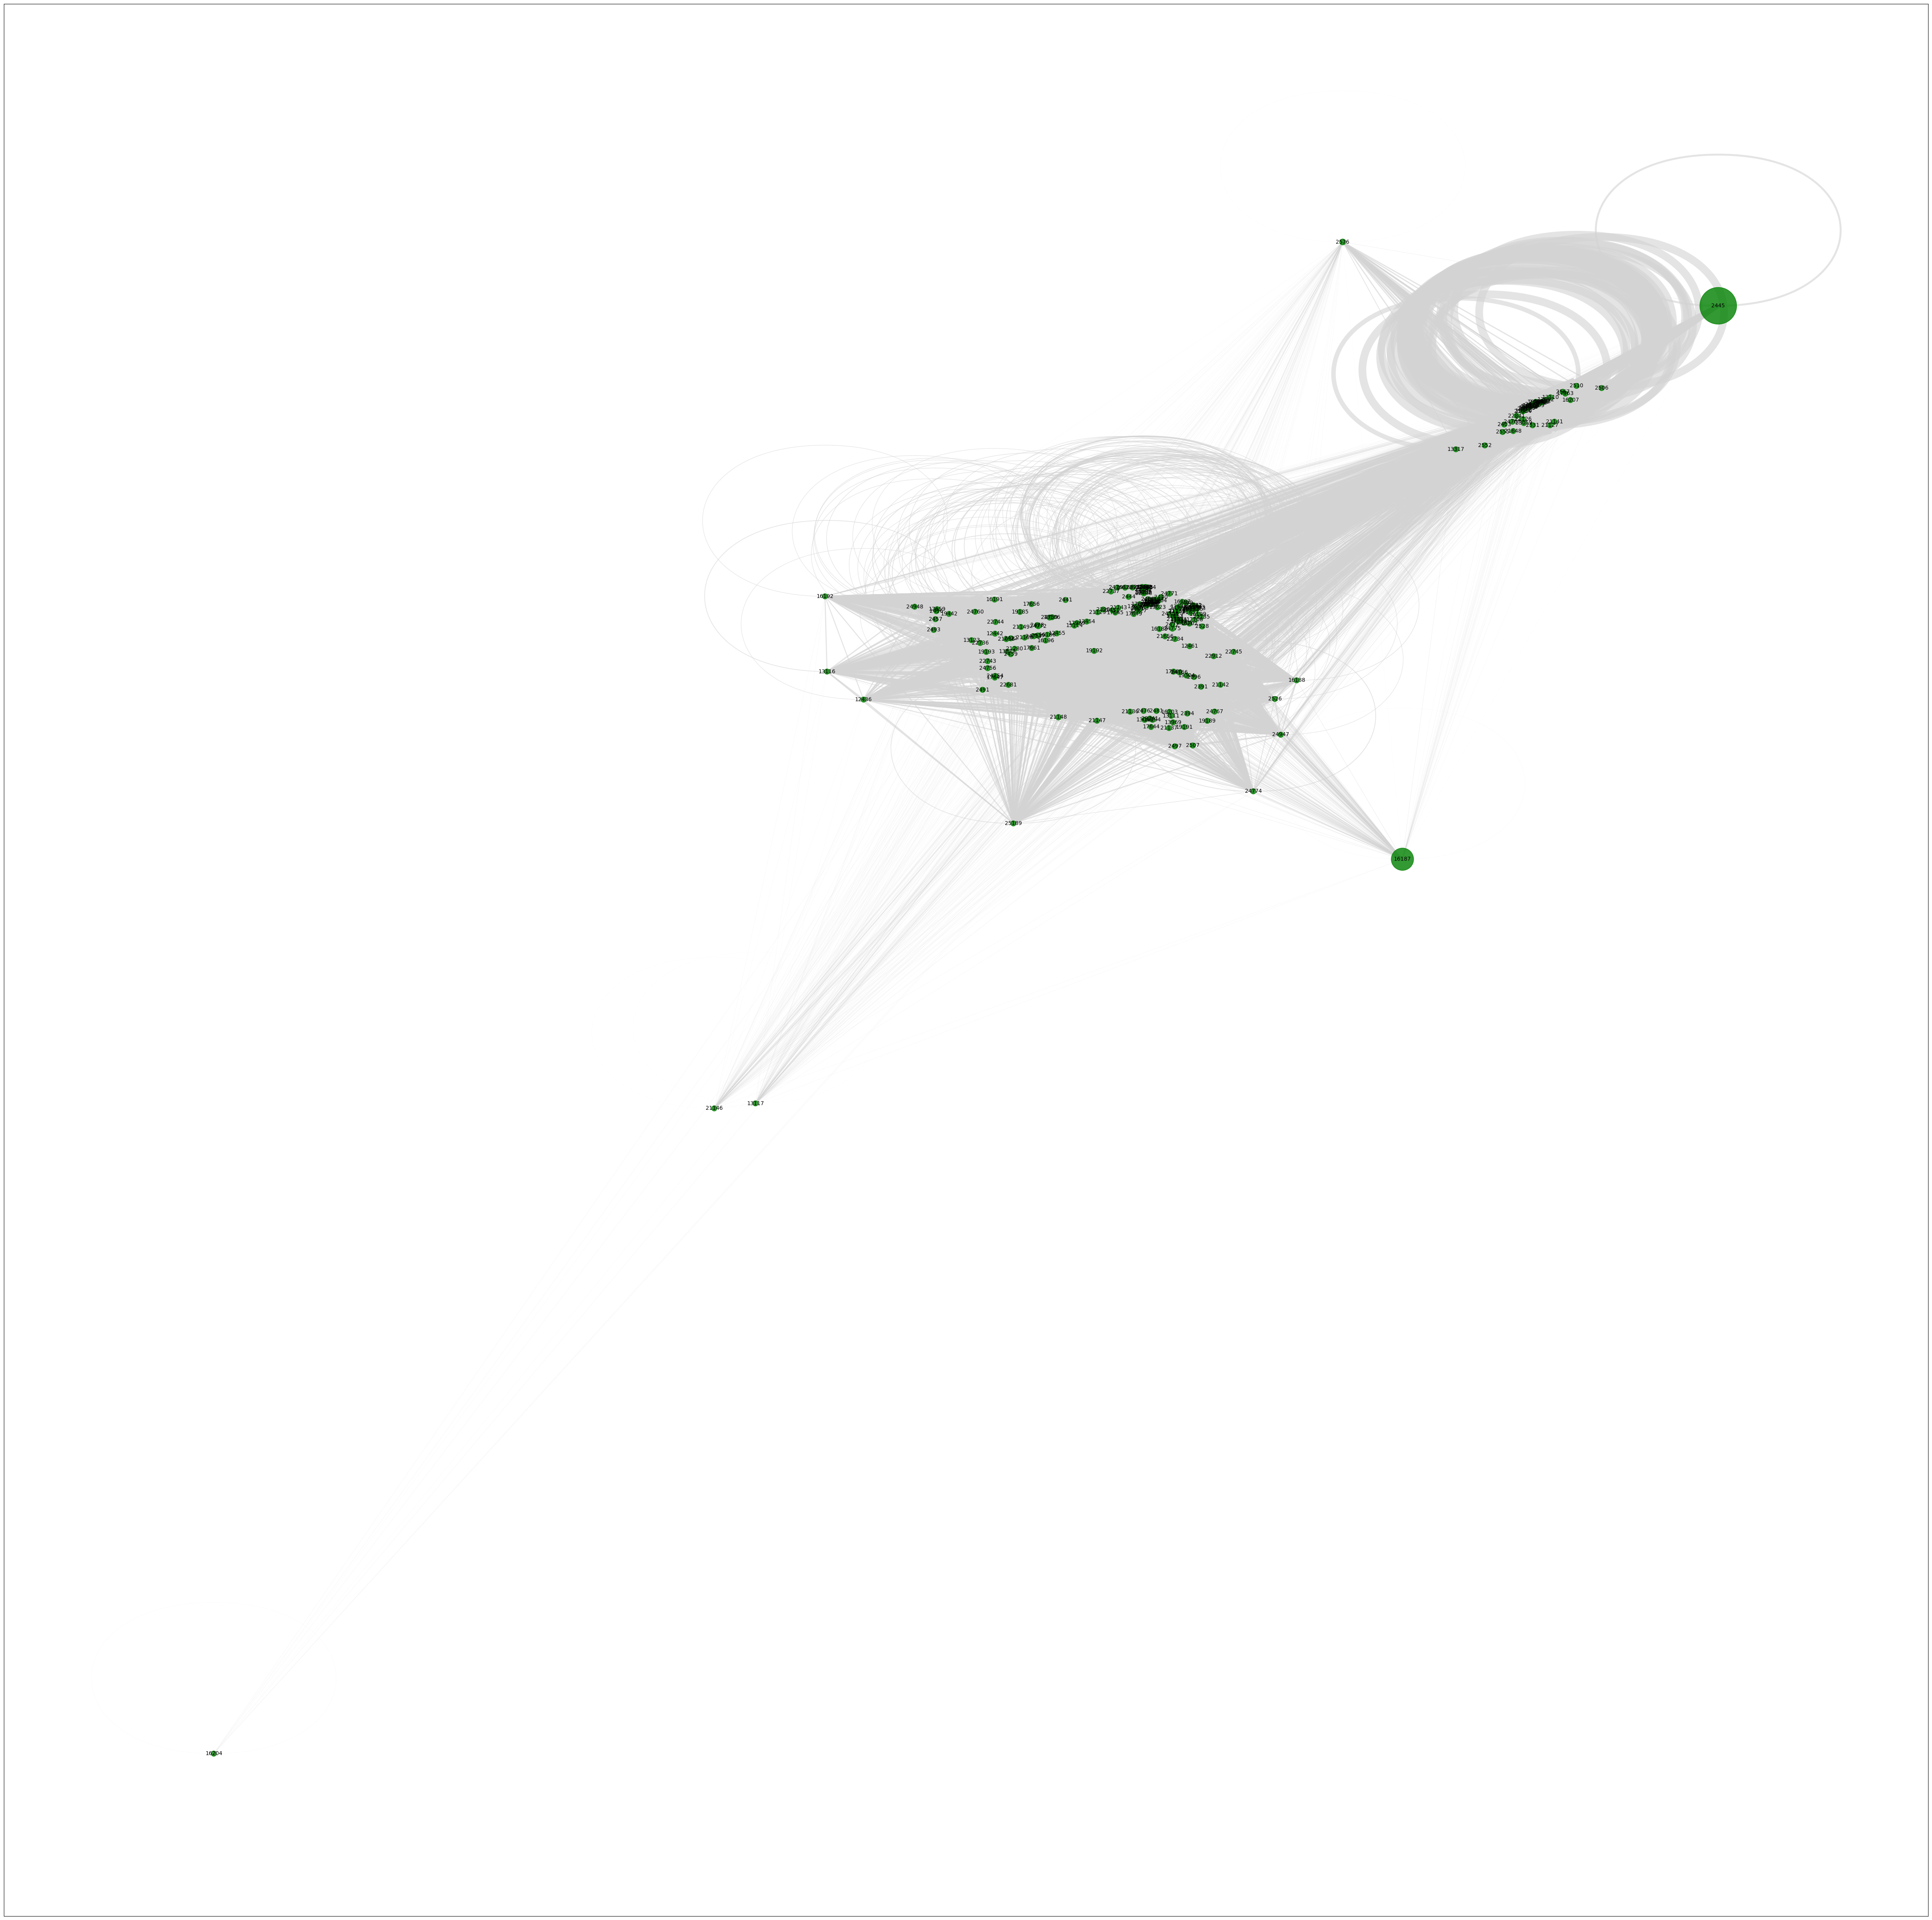

In [ ]:

#TODO this thing is has self-loops and the nodes are hard to interpret, the edges too
betweenness = nx.betweenness_centrality(G_covote, weight='weight')
node_size = [max(val * 5000, 100) for val in betweenness.values()]

edge_width = [d["weight"] /100 for (_, _, d) in G_covote.edges(data=True)]

plt.figure(figsize=(64, 64))
pos = nx.spring_layout(G_covote, seed=42)

nx.draw_networkx_nodes(G_covote, pos, node_size=node_size, node_color="green", alpha=0.8)
nx.draw_networkx_edges(G_covote, pos, width=edge_width, edge_color='lightgray', alpha=0.6)
nx.draw_networkx_labels(G_covote, pos, font_size=10)

plt.show()
